# Chapter 2

## Fine-tuning Transformers, p. 45

### Starting off with a pretrained DistilBERT model

See [`distilbert-base-uncased`](https://huggingface.co/distilbert-base-uncased) at 🤗 Models.

We choose our checkpoint here, and start off by setting up a tokenizer.

In [1]:
checkpoint = "distilbert-base-uncased"

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [3]:
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


----

## Load up the dataset

In [4]:
from datasets import load_dataset

emotions = load_dataset("SetFit/emotion")
emotions

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [5]:
def tokenize_text(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [6]:
emotions_encoded = emotions.map(tokenize_text, batched=True, batch_size=None)
emotions_encoded

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-ad2649c8346e0844.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c254f6d248d17bc6.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

----

### Loading a pretrained model

In [7]:
id2label = dict(
    zip(
        emotions["train"].unique('label'), 
        emotions["train"].unique('label_text')
    )
)

id2label = dict(sorted(id2label.items(), key=lambda item: item[0]))
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [8]:
num_labels = len(id2label)

In [9]:
labels = id2label.values()

In [10]:
label2id = {v:k for k,v in id2label.items()}

In [11]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(
             checkpoint, 
             num_labels=num_labels,
             id2label=id2label,
             label2id=label2id
         ).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

----

### Defining the performance metrics

Important APIs:

* [`sklearn.metrics.accuracy_score`]()
* [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

`f1_score`'s `average=weighted` parameter...?
> Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

Compare this approach with that used in the 00_simple_training.ipynb notebook, section **Dealing with imbalanced classes**

In [12]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return { "accuracy": acc, "f1": f1 }

----

### Training the model

In [13]:
from transformers import TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

model_name = f"{checkpoint}-finetuned-emotion"

"""
training_args = TrainingArguments(
    optim="adamw_torch",
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)
"""
training_args = TrainingArguments(
    optim="adamw_torch",
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_steps=logging_steps,
    fp16=True,
    push_to_hub=False,
    report_to="all"
)

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_text, text. If label_text, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16000
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 66958086
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.786400,0.265840,0.919000,0.917539
2,0.207900,0.177990,0.927000,0.927307
3,0.138500,0.156669,0.938000,0.938304
4,0.109100,0.150176,0.932500,0.931834
5,0.091200,0.145752,0.940000,0.940305


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_text, text. If label_text, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to distilbert-base-uncased-finetuned-emotion/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-emotion/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-emotion/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-emotion/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-emotion/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have bee

TrainOutput(global_step=1250, training_loss=0.2666071472167969, metrics={'train_runtime': 66.6552, 'train_samples_per_second': 1200.207, 'train_steps_per_second': 18.753, 'total_flos': 1800857154240000.0, 'train_loss': 0.2666071472167969, 'epoch': 5.0})

In [15]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_text, text. If label_text, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


{'test_loss': 0.14575232565402985,
 'test_accuracy': 0.94,
 'test_f1': 0.940305023826161,
 'test_runtime': 0.5504,
 'test_samples_per_second': 3634.017,
 'test_steps_per_second': 58.144}

In [16]:
import numpy as np

y_preds = np.argmax(preds_output.predictions, axis=1)

y_valid = np.array(emotions_encoded["validation"]["label"])

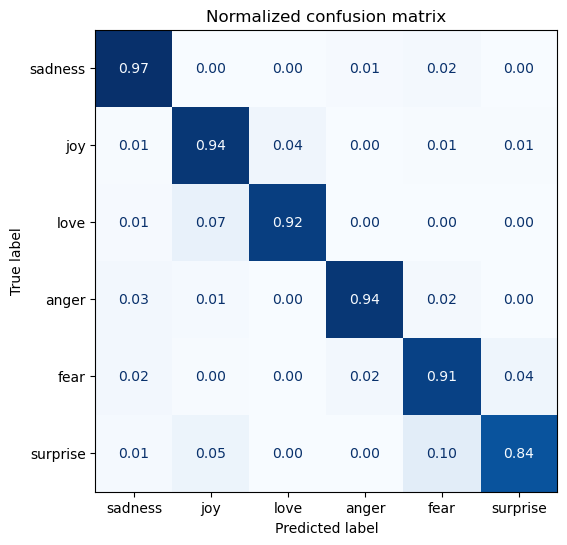

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    disp.plot(
        cmap="Blues",
        values_format=".2f",
        ax=ax,
        colorbar=False
    )
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

----

### Error analysis

In [18]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # place all input tensors on the same device as the model!
    inputs = {
        k:v.to(device)
        for k,v in batch.items()
        if k in tokenizer.model_input_names
    }
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(
            output.logits,
            batch["label"].to(device),
            reduction="none"
        )
       
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }
            

In [19]:
emotions_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)

emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [20]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(lambda v: id2label[v])
df_test["predicted_label"] = df_test["predicted_label"].apply(lambda v: id2label[v])

In [21]:
df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.003266
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.003261
2,i feel like a faithful servant,love,love,0.382373
3,i am just feeling cranky and blue,anger,anger,0.005516
4,i can have for a treat or if i am feeling festive,joy,joy,0.003100


In [22]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,7.401497
1950,i as representative of everything thats wrong ...,surprise,sadness,6.697650
1509,i guess this is a memoir so it feels like that...,joy,fear,6.346297
1111,im lazy my characters fall into categories of ...,joy,fear,5.683855
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.288568
1801,i feel that he was being overshadowed by the s...,love,sadness,5.065451
1840,id let you kill it now but as a matter of fact...,joy,fear,4.915080
1836,i got a very nasty electrical shock when i was...,fear,anger,4.911483
1683,i had applied for a job and they had assured m...,anger,joy,4.680399
1963,i called myself pro life and voted for perry w...,joy,sadness,4.641700


In [23]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
131,i feel like a graph doesnt show the data accur...,joy,joy,0.002468
632,i feel he is an terrific really worth bet,joy,joy,0.002470
1976,i trust heavily when i feel that the trust is ...,joy,joy,0.002493
212,i own the brushes are constantly used and i fe...,joy,joy,0.002496
1829,i do connect with a family and feel my work is...,joy,joy,0.002511
1544,i feel that my charlie card is much more valua...,joy,joy,0.002517
564,i feel like i m just a good actress then maybe,joy,joy,0.002522
1723,i know how much work goes into the creation an...,joy,joy,0.002527
1198,i feel like i should also mention that there w...,joy,joy,0.002535
683,i am doing this namely for myself but i feel t...,joy,joy,0.002548


----

### Testing the model

Now we will check out our newly-trained model.

In [24]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="distilbert-base-uncased-finetuned-emotion/checkpoint-1000"
)

loading configuration file distilbert-base-uncased-finetuned-emotion/checkpoint-1000/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-emotion/checkpoint-1000",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  

In [25]:
test_tweet = "That brunch was simply delicious!"

# you need to sort by label (id)
preds = sorted(
    classifier(test_tweet, top_k=None),
    key=lambda v: label2id[v["label"]]
)
#print(preds)

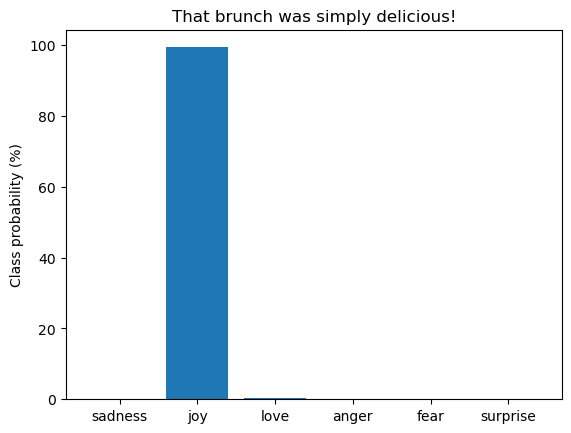

In [26]:
import pandas as pd

preds_df = pd.DataFrame(preds)

plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f"{test_tweet}")
plt.ylabel("Class probability (%)")

plt.show()